# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

Each video is a sequence of 30 frames (or images). 

## Data 

We can get the data from the following link.
https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

## Outcomes or Goal for the project

You need to accomplish the following in the project:

1. **Generator :** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model :** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up :** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

#### There are certain things you should keep in mind before proceeding further:

* Use the correct container: 'Tensorflow 1.5.0 GPU Py3' when you are using a GPU machine, else it'll throw an error similar to 'the kernel died'.
* Use a C2/CPU machine to get the data on your persistent storage.
* Whenever you modify your model, run the notebook from the beginning. This is to reset the initialisations and the generator.
* To check the GPU usage, execute 'nvidia-smi' on the terminal.

In [1]:
## Importing the required libraries

import numpy as np
import os
import pathlib
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import time

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
## Importing some other libraries

from PIL import Image, ImageFilter, ImageEnhance
import warnings
import cv2
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [4]:
## Importing Model building and related libraries

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, GRU, TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
import abc

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
## Mount Google Drive to load the data from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
project_folder = '/content/gdrive/My Drive/Project_data'
train_csv = project_folder + '/' + 'train.csv'
val_csv = project_folder + '/' + 'val.csv'

train_doc = np.random.permutation(open(train_csv).readlines())
val_doc = np.random.permutation(open(val_csv).readlines())
batch_size = 50

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
## Let us define a class for the generator and some other required functions

class ModelBuilder(metaclass = abc.ABCMeta) :

  ## Defining the Training and Validation Project data paths
  def initialize_path(self, project_folder) :
    self.train_csv = np.random.permutation(open(train_csv).readlines())
    self.val_csv = np.random.permutation(open(val_csv).readlines())
    self.train_data = project_folder + '/train'
    self.val_data = project_folder + '/val'
    self.num_train_sequences = len(self.train_csv)
    self.num_val_sequences = len(self.val_csv)

  ## Method to initializing Image properties
  def initialize_properties(self, img_height=100, img_width=100) :
    self.img_height = img_height
    self.img_width = img_width
    self.num_of_classes = 5
    self.total_frames = 30
    self.channels = 3

  ## Method to initialize the Hyperparameters
  def initialize_hyperparameters(self, batch_size = 30, epochs = 30, frames_to_sample = 30) :
    self.frames_to_sample = frames_to_sample
    self.batch_size = batch_size
    self.epochs = epochs

  ## Method for training a model and returning history after fit.generator. 
  def training_model(self, model, augment_data = False) :
    
    ## Let us create the train_generator and the val_generator which will be used in .fit_generator.
    train_generator = self.generator(self.train_data, self.train_csv, batch_size, augmentation = augment_data)
    val_generator = self.generator(self.val_data, self.val_csv, batch_size)

    ## Below code helps in saving our models
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    # Write the REducelronplateau code here
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]

    ## The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make
    if (self.num_train_sequences % self.batch_size) == 0:
       steps_per_epoch = int(self.num_train_sequences / self.batch_size)
    else:
        steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

    if (self.num_val_sequences % self.batch_size) == 0:
        validation_steps = int(self.num_val_sequences / self.batch_size)
    else:
        validation_steps = (self.num_val_sequences // self.batch_size) + 1

    ## Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model
    ## at the end of each epoch.
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    return history

  def generator(self,source_path, folder_list, batch_size=15, augmentation=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augmentation)
                yield batch_data, batch_labels 

            remaining_seq=len(t) % batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augmentation,remaining_seq)
                yield batch_data, batch_labels 
    
    
  def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augmentation,remaining_seq=0):
  
      seq_len = remaining_seq if remaining_seq else batch_size
  
      batch_data = np.zeros((seq_len,len(img_idx),self.img_height,self.img_width,self.channels)) 
      batch_labels = np.zeros((seq_len,self.num_of_classes)) 
  
      if (augmentation): 
        batch_data_aug = np.zeros((seq_len,len(img_idx),self.img_height,self.img_width,self.channels))

      
      for folder in range(seq_len): 
          imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
          for idx,item in enumerate(img_idx):
              #performing image reading and resizing
              image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
              image_resized=imresize(image,(self.img_height,self.img_width,3))
          
              #normalizing the images
              batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
              batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
              batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
          
              if (augmentation):
                  shifted = cv2.warpAffine(image, 
                                            np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                          (image.shape[1], image.shape[0]))
                  
                  gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                  x0, y0 = np.argwhere(gray > 0).min(axis=0)
                  x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                  # cropping the images to have the targeted gestures and remove the noise from the images.
                  cropped=shifted[x0:x1,y0:y1,:]
                  
                  image_resized=imresize(cropped,(self.img_height,self.img_width,3))
                  
                  #shifted = cv2.warpAffine(image_resized, 
                  #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                  #                        (image_resized.shape[1], image_resized.shape[0]))
          
                  batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                  batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                  batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
              
          
          batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          
  
      if (augmentation):
          batch_data=np.concatenate([batch_data,batch_data_aug])
          batch_labels=np.concatenate([batch_labels,batch_labels])

      
      return(batch_data,batch_labels)
  
  @abc.abstractmethod
  def init_Model(self) :
    pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'

curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 3 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 3


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Let us first begin with some parameter tuning experiments by creating a sample Model and executing with different parameters

In [9]:
class Conv3D_Model(ModelBuilder) :
  def init_Model(self, kernelSize=(3,3,3)) :

    model = Sequential()
    #First Convulation layer
    model.add(Conv3D(32, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                     activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Dropout layer with 30% Fraction of the input units to drop.
    model.add(Dropout(0.3))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])

    return model

In [10]:
## Creating an object for the Model Builder class
conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=15, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    27680     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 80, 80, 32)   128       
 hNormalization)                                                 
                                                        

In [11]:
## Let us test the generator function as well

test_generator_obj = Conv3D_Model()
test_generator_obj.initialize_path(project_folder)
test_generator_obj.initialize_properties(img_height=160, img_width=160)
test_generator_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=15, epochs=3)

generator = test_generator_obj.generator(test_generator_obj.val_data, test_generator_obj.val_csv, augmentation=True, batch_size=15)
batch_data, batch_labels = next(generator)


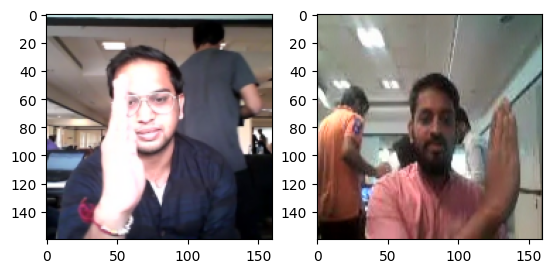

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,10,:,:,:])   
axes[1].imshow(batch_data[6,18,:,:,:])

#### Let us experiment to get various parameters and check that certain optimized parameter values

In [13]:
## We will try to get the limit on memory sources

## Creating an object for the Model Builder class
conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size = 40, epochs= 2)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

Epoch 1/3


ResourceExhaustedError: ignored

We will experiment with differnt batch sizes, sample frames and image resolutions to get the trade of between them and the time taken for each model

In [14]:
## Experimenting with batch size = 15, image size = 100 X 100, sample frames = 20

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=100, img_width=100)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=15, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/3
45/45 [==============================] - ETA: 0s - loss: 1.7460 - categorical_accuracy: 0.3725  
Epoch 1: saving model to model_init_2023-05-2711_20_34.485481/model-00001-1.74600-0.37255-2.26964-0.18000.h5
45/45 [==============================] - 8816s 200s/step - loss: 1.7460 - categorical_accuracy: 0.3725 - val_loss: 2.2696 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/3
45/45 [==============================] - ETA: 0s - loss: 1.5068 - categorical_accuracy: 0.4419
Epoch 2: saving model to model_init_2023-05-2711_20_34.485481/model-00002-1.50682-0.44193-2.50101-0.20000.h5
45/45 [==============================] - 140s 3s/step - loss: 1.5068 - categorical_accuracy: 0.4419 - val_loss: 2.5010 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/3
45/45 [==============================] - ETA: 0s - loss: 1.2436 - categorical_accuracy: 0.5098
Epoch 3: saving model to model_init_2023-05-2711_20_34.485481/model-00003-1.24355-0.50980-3.07705-0.19000.h5
45/45 [============

In [ ]:
## Experimenting with batch size = 15, image size = 160 X 160, sample frames = 20

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=15, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

In [ ]:
## Experimenting with batch size = 20, image size = 160 X 160, sample frames = 20

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=20, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

In [ ]:
## Experimenting with batch size = 20, image size = 160 X 160, sample frames = 30

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=20, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

In [ ]:
## Experimenting with batch size = 30, image size = 160 X 160, sample frames = 30

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=30, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

### Experiment Observations

*
*
*

### Model 1

Batch Size = 35 and No of Epochs = 16

In [ ]:
class Conv3D_Model(ModelBuilder) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.3, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(32, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Dropout layer with 30% Fraction of the input units to drop.
    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model                  

In [ ]:
conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=35, epochs=16)
conv_obj_model = conv_obj.init_Model()
conv_obj_model.summary()

In [ ]:
model_1_History = conv_obj.training_model(conv_obj_model)

In [ ]:
## User defined method to plot the Accuracy and Validation Plots

def plot_accuracyAndLoss(history, epochs) :
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(10, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.grid(color = 'teal', linestyle = '--', linewidth = 0.5)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.grid(color = 'teal', linestyle = '--', linewidth = 0.5)
  plt.show()

In [ ]:
plot_accuracyAndLoss(model_1_History, epochs = 16)

### Model 1 Observations



### Model 2

Reducing the Image resolution to 120 X 120, batch to 25, and kernel size = (increasing epochs to 20.

### Model 3

Inreasing the dropout from 0.3 to 0.5 and epochs = 20 reducing the batch size from 35 to 20

In [12]:
conv_obj_2 = Conv3D_Model()
conv_obj_2.initialize_path(project_folder)
conv_obj_2.initialize_properties(img_height=160, img_width=160)
conv_obj_2.initialize_hyperparameters(frames_to_sample=20, batch_size=20, epochs=20)
conv_obj_model_2 = conv_obj_2.init_Model(dropout=0.5, dense_Neurons=128)
conv_obj_model_2.summary()

In [ ]:
model_2_History = conv_obj.training_model(conv_obj_model_2)

In [ ]:
plot_accuracyAndLoss(model_2_History, epochs = 16)

### Model- 3 Observations

### Model 4

